## P1: Instantaneous Source Separation

In [561]:
#Point-2: Loading x_ica_1.wav to x_ica_20.wav files and storing in a list
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
X =[]
for i in range(20):
    file_name = 'data/x_ica_'+str(i+1)+'.wav'
    (sampling_rate,amplitudes) = wavfile.read(file_name)
    max_value = max(amplitudes)
    Norm_amplitudes = amplitudes/max_value
    X.append(Norm_amplitudes)

In [562]:
# Converting List to matrix
X = np.array(X)
print("No. of Recordings: ",X.shape[0])
N=X.shape[1]
print("N (Time domain samples for each Recording): ",N)
print("Sampling Rate: ",sampling_rate)

No. of Recordings:  20
N (Time domain samples for each Recording):  76800
Sampling Rate:  16000


Lets apply ICA Model for source seperation(K clean speech sources) on 20 input recordings.
* A Usual pipeline for ICA1
    * Whiten the data using PCA
        * Drop some eigenvectors if dimension reduction is needed
    * Do ICA

Need to deciside on  K i.e number of dimensions to keep after PCA

In [563]:
#Point-4: PCA with the whitening option.
from sklearn.decomposition import PCA
pca = PCA(n_components=6,whiten=True)
pca.fit(X.T)
print("Explained Variance Ratio: ",np.round(pca.explained_variance_,5))
print("Cummulative Explained Variance Ratio: ",np.round(pca.explained_variance_ratio_.cumsum(),5))

Explained Variance Ratio:  [0.67032 0.0913  0.0379  0.01935 0.      0.     ]
Cummulative Explained Variance Ratio:  [0.81859 0.93009 0.97637 1.      1.      1.     ]


* It can be observed that Explained Variance Ratio after 4th component is almost zero. So we can proceed with 4 components
* K=4

Lets findout reduced data matrix Z (K x N)

In [567]:
#Point-5: reduced data matrix Z (K x N)
K=4
pca_4 = PCA(n_components=K,whiten=True)
pca_4.fit(X.T)
Z = pca_4.transform(X.T).T
print("shape of reduced matrix Z: ",Z.shape)

shape of reduced matrix Z:  (4, 76800)


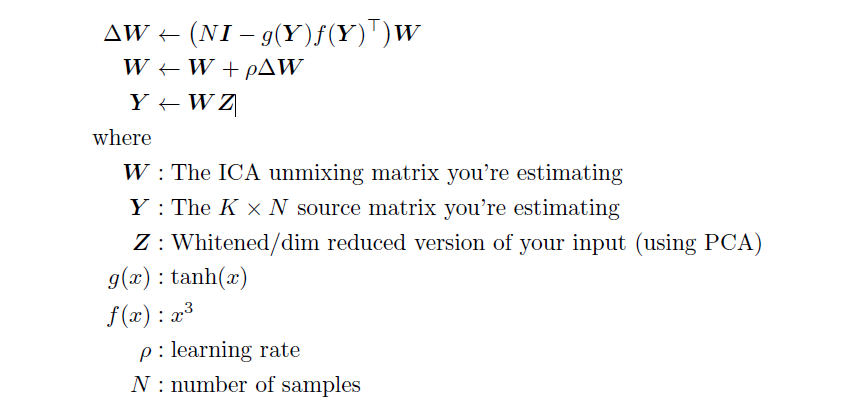

In [575]:
import copy
#Point-5: ICA algorithm with update rules:
I = np.identity(K)
learning_rate = 1e-7
W = np.identity(K) #np.ones((K,K)) #
Y = W@Z
conv=False
error=[]
i=0

In [576]:
while not conv:
    i+=1
    old_W = copy.deepcopy(W)
    delta_W = ((N*I)-(np.tanh(Y)@np.power(Y,3).T))@W
    W = W+learning_rate * delta_W
    Y = W@Z
    conv = np.allclose(W,old_W,rtol = 1e-4, atol = 1e-4)
    cov_limit = np.linalg.det(np.abs(old_W - W)) #   np.linalg.norm(W - old_W) #np.abs(np.linalg.det(delta_W))
    error.append(cov_limit)
print("Number of Iterations: ",i)

Number of Iterations:  1007


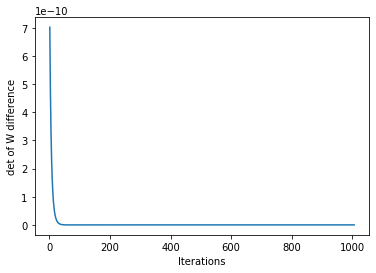

In [582]:
from matplotlib import pyplot as plt
plt.plot(list(range(1, i+1)),error)
plt.xlabel('Iterations')
plt.ylabel("det of W difference")
plt.show()

In [584]:
for i in range(4):
    wavfile.write("y_ica_"+str(i+1)+".wav", 16000, Y[i])

In [585]:
# Source Audio 1
ipd.display(Audio(Y[0], rate=16000))

In [586]:
# Source Audio 2
ipd.display(Audio(Y[1], rate=16000))

In [587]:
# Source Audio 3
ipd.display(Audio(Y[2], rate=16000))

In [588]:
# Source Audio 4
ipd.display(Audio(Y[3], rate=16000))

# P2: Ideal Masks

In [590]:
#Point-1: Loading piano.wav and ocean.wav files 
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy.signal as signal
import IPython.display as ipd
(piano_sr,piano) = wavfile.read("data/"+"piano.wav")
(ocean_sr,ocean) = wavfile.read("data/"+"ocean.wav")
print("Time domain samples: ",piano.shape[0])
print("Sampling Rate: ",piano_sr)

Time domain samples:  80000
Sampling Rate:  16000


In [591]:
ipd.Audio("data/"+'piano.wav')

In [592]:
ipd.Audio("data/"+'ocean.wav')

In [593]:
#Normalizing Amplitudes as scipy.io dosn't handle like librosa
max_value=max(piano)
piano=piano/max_value

max_value=max(ocean)
ocean=ocean/max_value

Freq_S,Time_S,S= signal.stft(piano,nperseg=1024,window='hann')

Freq_N,Time_N,N= signal.stft(ocean,nperseg=1024,window='hann')

In [594]:
S.shape,N.shape

((513, 158), (513, 158))

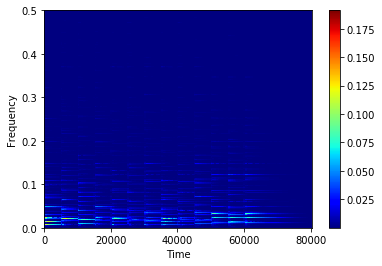

In [595]:
plt.pcolormesh(Time_S, Freq_S, np.abs(S),cmap='jet')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

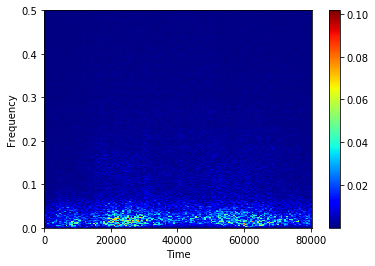

In [597]:
plt.pcolormesh(Time_N, Freq_N, np.abs(N),cmap='jet')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [598]:
#Point-2 mixture spectrogram by  X = S +N.
X=S+N

## why we need N/2 + 1 and not  N/2??

Lets create a sine wave with 16 samples and check complex coefficients after applying DFT

In [288]:
rand_samp = np.linspace(1,16,16)
np.fft.fft(np.sin(rand_samp), n=None, axis=-1, norm=None)

array([ 1.64778416+0.j        ,  1.79589646+0.89933376j,
        2.95830555+3.82130193j, -1.27530597-5.2837368j ,
        0.26642799-1.66838866j,  0.5297109 -0.90230716j,
        0.62638787-0.51098735j,  0.6671086 -0.23560185j,
        0.67868878+0.j        ,  0.6671086 +0.23560185j,
        0.62638787+0.51098735j,  0.5297109 +0.90230716j,
        0.26642799+1.66838866j, -1.27530597+5.2837368j ,
        2.95830555-3.82130193j,  1.79589646-0.89933376j])

## It can be observed that, there are 2 real numbers which doesn't have complex conjugates. By discarding the complex conjugates, we will end up with (N-2)/2 + 2 = (N/2)+1

In [601]:
#Point-4 estimate a nonnegative real-valued masking matrix M_bar
M_bar=np.divide(np.power(np.abs(S),2),np.add(np.power(np.abs(S),2),np.power(np.abs(N),2)))

In [604]:
#Point-4 Estimated Piano (S) spectogram
Estimated_S = np.multiply(M_bar,X)
Time_freq,S_recovered=signal.istft(Estimated_S,nperseg=1024,window='hann')

In [605]:
# Recovered piano source
ipd.Audio(S_recovered, rate=16000)

In [606]:
print("Length of original source: ", piano.shape[0] )
print("Length of recovered source: ", S_recovered.shape[0] )

Length of original source:  80000
Length of recovered source:  80384


In [607]:
#Point-5: SNR

ratio=np.divide(np.sum(np.square(piano)),np.sum(np.square(np.subtract(piano,S_recovered[0:piano.shape[0]]))))
SNR=10*np.log10(ratio)
print("SNR between piano.wav and your reconstruction: ",SNR)

SNR between piano.wav and your reconstruction:  8.116028105150077


In [608]:
#point-6: Ideal Binary Masks
B_ft = (S > N).astype(int)

In [609]:
#Point-7: 
S_IBM = np.multiply(B_ft,X)
Time_freq,S_recovered_IBM=signal.istft(S_IBM,nperseg=1024,window='hann')

ratio_IBM=np.divide(np.sum(np.square(piano)),np.sum(np.square(np.subtract(piano,S_recovered_IBM[0:piano.shape[0]]))))
SNR_IBM=10*np.log10(ratio_IBM)
print("SNR between piano.wav and after applying IBM: ",SNR_IBM)


SNR between piano.wav and after applying IBM:  1.6133649938727341


In [611]:
# Recovered piano source
ipd.Audio(S_recovered_IBM, rate=16000)

#### Recovered source by IBM is noisy and has low SNR value. While, source recovered by IRM is lot clearer with high SNR.

## P3: Single-channel Source Separation

In [628]:
import numpy as np
from scipy.io import wavfile
import scipy.signal as signal

In [629]:
#Point-1: Loading all 3 files
(trs_sr,trs)=wavfile.read("data/"+'trs.wav')
(trn_sr,trn)=wavfile.read("data/"+'trn.wav')
(x_nmf_sr,x_nmf)=wavfile.read("data/"+'x_nmf.wav')

In [630]:
max_value=max(trs)
trs=trs/max_value

max_value=max(trn)
trn=trn/max_value

max_value=max(x_nmf)
x_nmf=x_nmf/max_value

In [631]:
_,_,S_spect=signal.stft(trs,trs_sr,nperseg=1024)
# magnitude spectrogram
S=np.absolute(S_spect)
S.shape

(513, 990)

In [632]:
def nmf(W,H,X):
    conv =False
    atol=1e-05
    while not conv:
        old_W = copy.deepcopy(W)
        
        W=np.multiply(W,((X@H.T)/((W@H)@H.T)))
        H=np.multiply(H,((W.T@X)/((W.T@W)@H)))
        
        conv = np.allclose(W,old_W,atol=atol)
        
    return W,H

In [634]:
#Point-1: lets learn NMF model with 30 basis vectors for S (trs.wav)
W_S_int=np.random.rand(S.shape[0],30)
H_S_int=np.random.rand(30,S.shape[1])

W_S,H_S=nmf(W_S_int,H_S_int,S)

In [635]:
_,_,N_spect=signal.stft(trn,trn_sr,nperseg=1024)
# magnitude spectrogram
N=np.absolute(N_spect)
N.shape

(513, 990)

In [636]:
#Point-2: lets learn NMF model with 30 basis vectors for N (trn.wav)
W_N_int=np.random.rand(N.shape[0],30)
H_N_int=np.random.rand(30,N.shape[1])

W_N,H_N=nmf(W_N_int,H_N_int,N)

In [637]:
#Point-3
_,_,X=signal.stft(x_nmf,x_nmf_sr,nperseg=1024)
# magnitude spectrogram
Y=np.absolute(X)
Y.shape

(513, 131)

In [638]:
W=np.concatenate((W_S,W_N),axis=1)
W.shape

(513, 60)

In [639]:
def activations(W,H,X):
    
    conv =False
    atol=1e-05
    while not conv:
        old_H = copy.deepcopy(H)
        H=np.multiply(H,((W.T@X)/((W.T@W)@H)))
        
        conv = np.allclose(H,old_H,atol=atol)
        
    return H

H=np.random.rand(W.shape[1],Y.shape[1])
H=activations(W,H,Y)
H.shape

(60, 131)

In [640]:
#Point-4: estimation of S and corresponding phase information
Estimated_S=W_S@H[:30,:]
phase=X/Y
Recovered_S=np.multiply(Estimated_S,phase)

In [641]:
_, S_t=signal.istft(Recovered_S,x_nmf_sr,nperseg=1024)
S_t.shape

(66560,)

In [642]:
import IPython.display as ipd
ipd.Audio(S_t, rate=x_nmf_sr)

In [643]:
#Point-5: creating a magnitude masking matrix
M_bar=Estimated_S/(W@H)
M_bar.shape

(513, 131)

In [644]:
mask_recovered_S=np.multiply(M_bar,X)
_, mask_S_t=signal.istft(mask_recovered_S,x_nmf_sr,nperseg=1024)

In [645]:
import IPython.display as ipd
ipd.Audio(mask_S_t, rate=x_nmf_sr)

#### Signal recovered in point-5 i.e using Magnitude masking matrix (IRM) is better and relatively cleaner than the one recovered  using phase information. So IRM result will have higher SRN value ( cleaner source has Higher SRN) 

# P4: Motor Imagery

In [833]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [834]:
#Point-2 Reading data
data = loadmat('data/eeg.mat')
x_train = data.get("x_train")
x_test = data.get("x_te")
y_train = data.get("y_train")
y_test = data.get("y_te")

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((768, 3, 112), (112, 1), (768, 3, 28), (28, 1))

In [844]:
def data_processing(x):
    X = []
    channels = x.shape[1]
    N = x.shape[2]
    for i in range(N):
        S = []
        for j in range(channels):
            ch_spec = signal.stft(x[:,j,i],fs=128,window='blackman',nperseg=64,noverlap=16)[2][3:8]
            ch_spec_mag=np.absolute(ch_spec).reshape(1,85)
            S.append(ch_spec_mag.flatten())
        S = np.array(S).flatten()
        X.append(S)
    X=np.array(X).T
    return X

In [943]:
def nmf(X,n):
    W=np.random.rand(X.shape[0],n)
    H=np.random.rand(n,X.shape[1])
#    W=np.ones((X.shape[0],n))
#    H=np.ones((n,X.shape[1]))
    conv =False
    while not conv:
        old_H = copy.deepcopy(H)
        
        W=np.multiply(W,((X@H.T)/((W@H)@H.T)))
        H=np.multiply(H,((W.T@X)/((W.T@W)@H)))
        
        conv = np.allclose(H,old_H, atol = 1e-4)
        
    return W,H

In [944]:
X_train = data_processing(x_train)
X_test = data_processing(x_test)
Y_train = y_train.flatten()
Y_test =y_test.flatten()

In [945]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((255, 112), (255, 28), (112,), (28,))

#### Used KNN with necessary modifications that is developed as part of EAI Assignment

In [946]:
# Finds k nearest neighbours in train data for a test example using Euclidean distance
def KNN_neighbors(train_data,train_label, test_data, k):

    # Calculates euclidean distance between test exmaple and all training data points
    # And stores a np array as [class,distance] for all points
    distances = np.column_stack([train_label, np.sqrt(np.sum(np.square(train_data - test_data), axis=1))])

    # Sorts based on distances and stores classes of k nearest points
    neighbors = list(distances[distances[:, 1].argsort()][:k:, 0])

    return max(set(neighbors), key=neighbors.count)


# Function KNN
def KNN_predict(train_data,train_label, test_data, k):
    y_pred = [KNN_neighbors(train_data,train_label, y, k) for y in test_data]

    return y_pred


# Calculates Accuracy
def accuracy_metric(y_act, y_pred):
    correct = (np.array(y_act) == np.array(y_pred)).sum()
    metric = correct / len(y_act)
    return metric * 100

In [961]:
rank=[2,4,6,8,10,15,20]
K=[3,5,7,10,15,20,30]
accuracies={}
accuracies_train={}
for i in rank:
    rank_acc=[]
    rank_acc_train=[]
    X_train_nmf=(nmf(X_train,i)[1]).T
    X_test_nmf=(nmf(X_test,i)[1]).T
    for j in K:
        y_pred = KNN_predict(X_train_nmf,Y_train, X_test_nmf, j)
        y_train_pred = KNN_predict(X_train_nmf,Y_train, X_train_nmf, j)
        accuracy=accuracy_metric(Y_test, y_pred)
        rank_acc.append(round(accuracy,2))
        accuracy_train=accuracy_metric(Y_train, y_train_pred)
        rank_acc_train.append(round(accuracy_train,2))
    accuracies[i]=np.array(rank_acc).T.tolist()
    accuracies_train[i]=np.array(rank_acc_train).T.tolist()

In [962]:
#Test Accuracies (Rank Wise)
accuracies

{2: [53.57, 46.43, 50.0, 53.57, 53.57, 53.57, 50.0],
 4: [39.29, 42.86, 42.86, 46.43, 46.43, 50.0, 53.57],
 6: [46.43, 42.86, 50.0, 42.86, 42.86, 42.86, 42.86],
 8: [46.43, 53.57, 53.57, 57.14, 64.29, 64.29, 64.29],
 10: [42.86, 39.29, 39.29, 39.29, 39.29, 32.14, 35.71],
 15: [35.71, 39.29, 46.43, 39.29, 42.86, 39.29, 39.29],
 20: [42.86, 42.86, 42.86, 46.43, 42.86, 53.57, 46.43]}

In [963]:
#Train Accuracies (Rank Wise)
accuracies_train

{2: [79.46, 79.46, 75.89, 74.11, 79.46, 80.36, 75.0],
 4: [91.07, 88.39, 85.71, 88.39, 87.5, 90.18, 85.71],
 6: [92.86, 90.18, 87.5, 85.71, 88.39, 87.5, 83.04],
 8: [90.18, 89.29, 84.82, 87.5, 87.5, 87.5, 83.93],
 10: [92.86, 91.07, 87.5, 85.71, 85.71, 90.18, 90.18],
 15: [88.39, 89.29, 89.29, 88.39, 87.5, 88.39, 87.5],
 20: [91.07, 88.39, 87.5, 83.93, 84.82, 83.04, 83.93]}

In [964]:
import pandas as pd
df_train_acc = pd.DataFrame(accuracies_train)
df_test_acc = pd.DataFrame(accuracies)

In [965]:
#Columns: Ranks= [2,4,6,8,10,15,20] and Rows: K = [3,5,7,10,15,20,30]
df_train_acc

,2,4,6,8,10,15,20
0,79.46,91.07,92.86,90.18,92.86,88.39,91.07
1,79.46,88.39,90.18,89.29,91.07,89.29,88.39
2,75.89,85.71,87.50,84.82,87.50,89.29,87.50
3,74.11,88.39,85.71,87.50,85.71,88.39,83.93
4,79.46,87.50,88.39,87.50,85.71,87.50,84.82
5,80.36,90.18,87.50,87.50,90.18,88.39,83.04
6,75.00,85.71,83.04,83.93,90.18,87.50,83.93


In [966]:
#Columns: Ranks= [2,4,6,8,10,15,20] and Rows: K = [3,5,7,10,15,20,30]
df_test_acc

,2,4,6,8,10,15,20
0,53.57,39.29,46.43,46.43,42.86,35.71,42.86
1,46.43,42.86,42.86,53.57,39.29,39.29,42.86
2,50.00,42.86,50.00,53.57,39.29,46.43,42.86
3,53.57,46.43,42.86,57.14,39.29,39.29,46.43
4,53.57,46.43,42.86,64.29,39.29,42.86,42.86
5,53.57,50.00,42.86,64.29,32.14,39.29,53.57
6,50.00,53.57,42.86,64.29,35.71,39.29,46.43


### BCI Classification Results:
#### Test Accuracies kind of followed bell curve with peak around PC= 8. 

### KNN Results:
#### we can observe similar results with peak around rank=8 and test accuracies are higher for big K's